In [10]:
from morphocycle.models.coatnet import create_model, Classifier

In [99]:


model = Classifier(num_classes=4,
                    pretrained=True,
                    )

In [101]:
model.state_dict()

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
                         -2.0325e-02,  8.8140e-03],
                        [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
                          2.9346e-02, -5.8331e-02],
                        [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
                          2.1868e-01, -7.2909e-02],
                        ...,
                        [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
                         -5.7855e-01,  2.2461e-01],
                        [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
                         -4.9317e-02, -6.8082e-02],
                        [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
                          1.8976e-01, -2.2302e-02]],
              
                       [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
                         -

In [23]:
import numpy as np
import torch
from torch.utils.data import Dataset
from pathlib import Path
import tifffile as tfl
import torchvision.transforms as T



class CellCycleData(Dataset):
    """
    Dataset class for the single cell dataset
    """

    def __init__(
        self,
        img_dir=None,
            split="train",
    ):
        # Set all input args as attributes
        self.__dict__.update(locals())
        self.img_dir = Path(img_dir)
        self.split = split

        # Get all the image files
        img_files = list(self.img_dir.glob("**/*/*/*.tif"))
        self.img_files = [i for i in img_files if ("NotKnown" not in str(i)) and
                          ("G1-S" not in str(i)) and
                          ("S-G2" not in str(i)) and
                          ("G2-M" not in str(i))]

        # Get all the labels
        labels = [str(x.parent.name) for x in self.img_files]
        self.label_dict = {"G1": 0,
                           # "G1-S": 10,
                           "S": 1,
                           # "S-G2": 30,
                           "G2": 2,
                           # "G2-M": 50,
                           "M": 3}

        self.labels = [self.label_dict[x] for x in labels]
        self.track_ids = [str(x.parent.parent.name) for x in self.img_files]
        self.slide_ids = [str(x.parent.parent.parent.name) for x in self.img_files]

    def __len__(self):
        return len(self.img_files)

    def __return_labels__(self, idx):
        img_path = self.img_files[idx]
        img = tfl.imread(img_path)

        if (img == 0).sum() >= (0.5 * img.shape[0] * img.shape[1]):
            return None
        else:
            label = torch.tensor(self.labels[idx])
            return label

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        img = tfl.imread(img_path)
        # v_min, v_max = img.min(), img.max()
        # new_min, new_max = 0, 255
        # img = np.clip(img, 0, None)
        # img = img/(img.max() + 1e-5)
        if (img == 0).sum()>=(0.5 * img.shape[0] * img.shape[1]):
            return None
        else:
            label = torch.tensor(self.labels[idx])

            img = (img - img.min()) / (img.max() - img.min() + 1e-5)

        # else:
        #     label=torch.tensor(4)
            if self.split == "train":
                transform = T.Compose([T.ToTensor(),
                                   T.RandomHorizontalFlip(p=0.5),
                                   T.RandomVerticalFlip(p=0.5),
                                   T.RandomRotation(degrees=90),
                                   # T.RandomPerspective(distortion_scale=0.5, p=0.5),
                                   T.Resize((64, 64))
                                   ])
            else:
                transform = T.Compose([T.ToTensor(),
                                       T.Resize((64, 64))
                                       ])

            img = transform(img)
            img = img.expand(3, *img.shape[1:]).type(torch.FloatTensor)

            track_id = self.track_ids[idx]
            slide_id = self.slide_ids[idx]


            return img, label, track_id, slide_id

In [34]:
import pytorch_lightning as pl
import torch.utils.data
from morphocycle.datasets.dataset import CellCycleData
from torch.utils.data import DataLoader
import numpy as np
import torch.utils.data as data
import torch

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

class CellCycleDataModule(pl.LightningDataModule):
    def __init__(
        self,
        img_dir=None,
        batch_size=1,
    ):
        super().__init__()
        # Set all input args as attributes
        self.__dict__.update(locals())
        self.img_dir = img_dir

    def setup(self, stage=None):
        train_set = CellCycleData(
            img_dir=self.img_dir,
            )
        # use 20% of training data for validation
        train_set_size = int(len(train_set) * 0.8)
        valid_set_size = len(train_set) - train_set_size

        # split the train set into two
        seed = torch.Generator().manual_seed(42)
        self.train_set, self.valid_set = data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

    def calculate_weights(self):
        labels = []
        for i in range(len(self.train_set)):
            if self.train_set[i] is not None:
                labels.append(self.train_set[i][1].item())

        class_sample_count = np.unique(labels, return_counts=True)[1]
        weight = 1. / class_sample_count
        samples_weight = weight[labels]
        weights = torch.from_numpy(samples_weight)

        return weights

    def train_dataloader(self):
        return DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            collate_fn=collate_fn,
            sampler=torch.utils.data.WeightedRandomSampler(
                weights=self.calculate_weights(), num_samples=len(self.train_set)
            ),
            num_workers=24,
        )

    def val_dataloader(self):
        return DataLoader(self.valid_set,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=24,
                          collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(self.valid_set,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=24,
                          collate_fn=collate_fn)


In [59]:
cell_data = CellCycleDataModule(
        "/mnt/nvme0n1/Datasets/PCNA_GT/",
        batch_size=128,
    )
cell_data.setup()

In [103]:
checkpoint = torch.load("/home/mvries/Documents/GitHub/MorphoCycle/logs/" \
                           "EfficientNet_Morphocycle/1hiz1n0o/checkpoints/epoch=383-step=9984.ckpt")

In [105]:
checkpoint['state_dict']

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.3706e-03, -1.7113e-03,  3.8645e-02,  ...,  4.8951e-02,
                         -1.9483e-02,  9.2646e-03],
                        [-5.7342e-02,  4.6362e-02,  7.8998e-02,  ...,  8.9863e-02,
                          3.0264e-02, -5.7792e-02],
                        [ 6.8219e-02, -2.6893e-01,  4.0519e-01,  ..., -1.6328e-01,
                          2.1962e-01, -7.2236e-02],
                        ...,
                        [-1.0868e-01,  3.8297e-01, -4.5342e-01,  ...,  6.8555e-01,
                         -5.7656e-01,  2.2570e-01],
                        [ 2.5440e-02, -1.7579e-01,  6.4548e-01,  ...,  5.2838e-01,
                         -4.7658e-02, -6.7043e-02],
                        [ 4.4829e-02, -1.2963e-01,  1.9385e-02,  ..., -3.5598e-01,
                          1.9115e-01, -2.1423e-02]],
              
                       [[ 8.9949e-03,  6.3438e-03, -1.4064e-02,  ...,  8.7964e-02,
                         -

In [107]:
model = model.load_from_checkpoint("/home/mvries/Documents/GitHub/MorphoCycle/logs/" \
                           "EfficientNet_Morphocycle/1hiz1n0o/checkpoints/epoch=383-step=9984.ckpt")
model.state_dict()

OrderedDict([('model.conv1.weight',
              tensor([[[[-7.3706e-03, -1.7113e-03,  3.8645e-02,  ...,  4.8951e-02,
                         -1.9483e-02,  9.2646e-03],
                        [-5.7342e-02,  4.6362e-02,  7.8998e-02,  ...,  8.9863e-02,
                          3.0264e-02, -5.7792e-02],
                        [ 6.8219e-02, -2.6893e-01,  4.0519e-01,  ..., -1.6328e-01,
                          2.1962e-01, -7.2236e-02],
                        ...,
                        [-1.0868e-01,  3.8297e-01, -4.5342e-01,  ...,  6.8555e-01,
                         -5.7656e-01,  2.2570e-01],
                        [ 2.5440e-02, -1.7579e-01,  6.4548e-01,  ...,  5.2838e-01,
                         -4.7658e-02, -6.7043e-02],
                        [ 4.4829e-02, -1.2963e-01,  1.9385e-02,  ..., -3.5598e-01,
                          1.9115e-01, -2.1423e-02]],
              
                       [[ 8.9949e-03,  6.3438e-03, -1.4064e-02,  ...,  8.7964e-02,
                         -

In [108]:
model.cuda()
model.eval()

Classifier(
  (criterion): CrossEntropyLoss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [131]:
model.cuda()

Classifier(
  (criterion): CrossEntropyLoss()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [132]:
from tqdm import tqdm

all_results = []

for d in cell_data.test_dataloader():
#     print(d[0].isnan().any())
    logits = model(d[0].cuda())
    y_prob = torch.softmax(logits, dim=1)
    y_hat = torch.argmax(y_prob, dim=1)
    all_results.append({
            "logits": logits.detach().cpu(),
            "Y_prob": y_prob.detach().cpu(),
            "Y_hat": y_hat.detach().cpu(),
            "label": d[1].double().detach().cpu(),
        })

In [133]:
logits = torch.cat([x["logits"] for x in all_results], dim=0)
probs = torch.cat([x["Y_prob"] for x in all_results], dim=0)
max_probs = torch.cat([x["Y_hat"] for x in all_results], dim=0)
target = torch.cat([x["label"] for x in all_results], dim=0)

In [134]:
target.device

device(type='cpu')

In [135]:
model.cpu().test_metrics(max_probs, target)

{'test_MulticlassAccuracy': tensor(0.8604),
 'test_MulticlassF1Score': tensor(0.8852),
 'test_MulticlassPrecision': tensor(0.9149),
 'test_MulticlassRecall': tensor(0.8604)}

In [136]:
torch.squeeze(target).detach().cpu().numpy().astype(np.uint8)

array([1, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 1,
       1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1,
       1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 3, 1, 2, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 3,
       1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 3, 3, 1, 1, 3, 0, 2, 0,
       1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 3, 2, 2, 1, 1,
       1, 1, 1, 1, 0, 3, 2, 1, 1, 2, 2, 1, 1, 3, 2, 1, 1, 0, 1, 2, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 3, 1, 1, 2, 1, 2, 1, 1, 2, 1, 3,
       1, 2, 1, 3, 1, 3, 1, 1, 2, 2, 0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 0, 1,
       2, 1, 1, 1, 3, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 2, 1, 1, 2, 1, 2, 1, 1, 3, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 0, 3, 1, 1, 1, 1, 1, 3, 2,

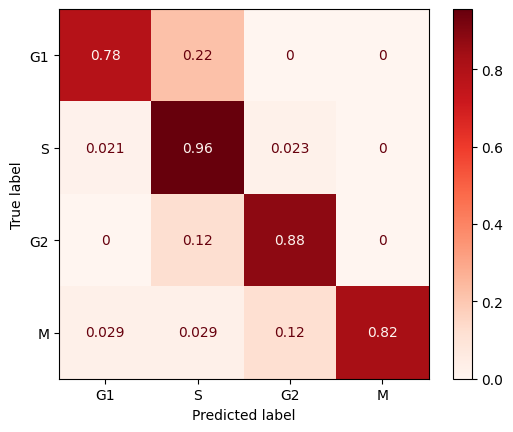

In [146]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['G1', 'S', 'G2', 'M']
cm = confusion_matrix(torch.squeeze(target).detach().cpu().numpy().astype(np.uint8),
            torch.squeeze(max_probs).detach().cpu().numpy(),
                     normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names,
                             )
disp.plot(cmap="Reds")
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



In [160]:
y_test = target.cpu().numpy().astype(np.uint8)
y_test
y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
y_test

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [161]:
y_pred_prob = probs.cpu().numpy()
y_pred_prob

array([[9.1513328e-05, 9.9969542e-01, 2.0079254e-04, 1.2290945e-05],
       [9.2519504e-06, 1.1747285e-02, 9.8823476e-01, 8.6868449e-06],
       [2.6495571e-04, 9.9939620e-01, 2.9618104e-04, 4.2618896e-05],
       ...,
       [2.9494627e-06, 9.9933845e-01, 6.5513462e-04, 3.4497218e-06],
       [3.3133416e-04, 9.3869013e-01, 6.0892262e-02, 8.6259388e-05],
       [4.2933924e-04, 9.9735165e-01, 2.1680254e-03, 5.0950715e-05]],
      dtype=float32)

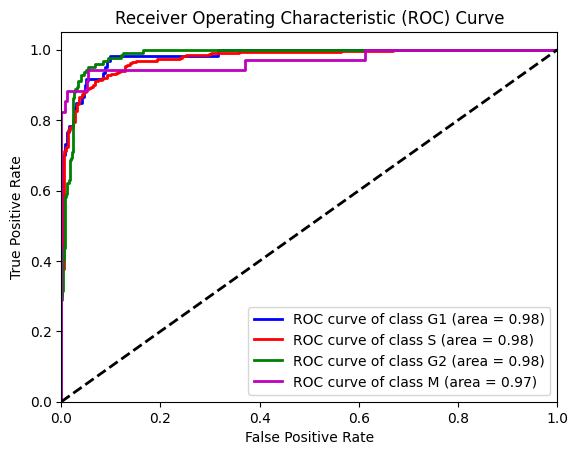

In [169]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'm']

for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



In [172]:
from sklearn.metrics import classification_report

print(classification_report(target.cpu().numpy().astype(np.uint8), max_probs.cpu().numpy()))


              precision    recall  f1-score   support

           0       0.84      0.78      0.81        60
           1       0.93      0.96      0.94       385
           2       0.89      0.88      0.89       124
           3       1.00      0.82      0.90        34

    accuracy                           0.92       603
   macro avg       0.91      0.86      0.89       603
weighted avg       0.92      0.92      0.91       603



In [177]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

y_test_original = target.cpu().numpy().astype(np.uint8)
y_pred = max_probs.cpu().numpy()

data = {
    'Precision': precision_score(y_test_original, y_pred, average=None),
    'Recall': recall_score(y_test_original, y_pred, average=None),
    'F1 Score': f1_score(y_test_original, y_pred, average=None),
    'Accuracy': [accuracy_score(y_test_original, y_pred)] * 4
}

df = pd.DataFrame(data, index=[f"Class {class_names[i]}" for i in range(4)])
print(df)


          Precision    Recall  F1 Score  Accuracy
Class G1   0.839286  0.783333  0.810345  0.915423
Class S    0.926952  0.955844  0.941176  0.915423
Class G2   0.893443  0.879032  0.886179  0.915423
Class M    1.000000  0.823529  0.903226  0.915423


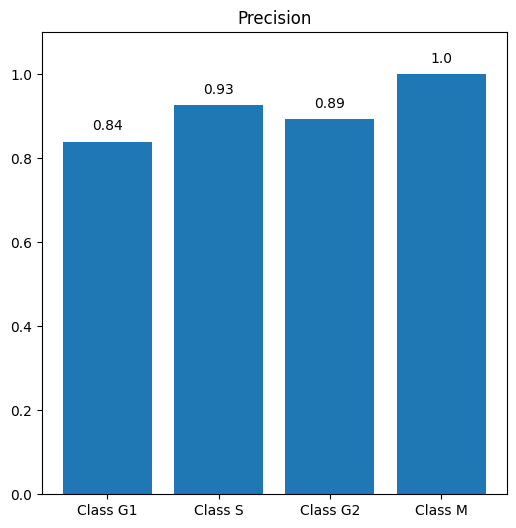

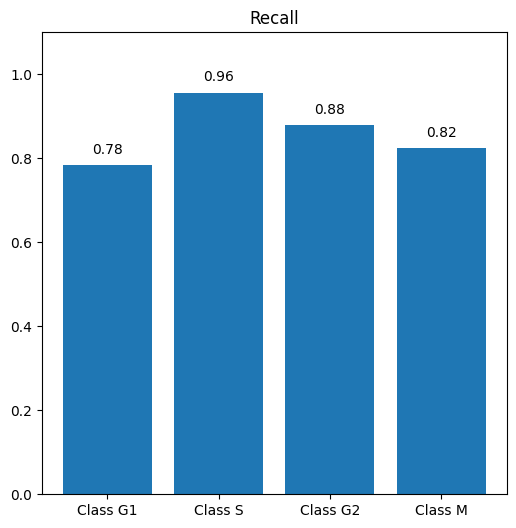

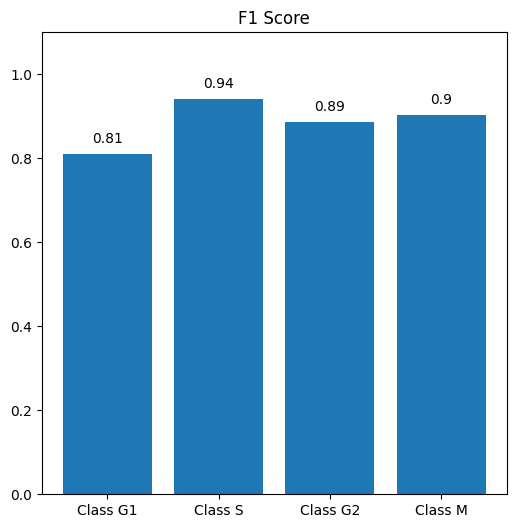

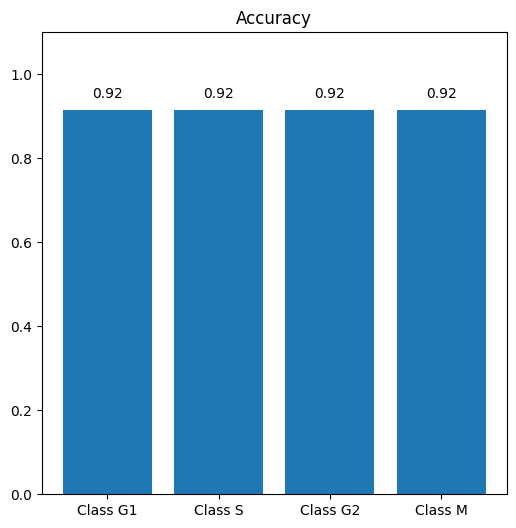

In [182]:
import matplotlib.pyplot as plt

metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
for metric in metrics:
    plt.figure(figsize=(6, 6))
    bars = plt.bar(df.index, df[metric])
    plt.title(metric)
    plt.ylim(0, 1.1)
    # Add the metric value on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')
        
    plt.savefig(f'{metric}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [140]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y_true, y_hats)

NameError: name 'y_true' is not defined

In [30]:
np.unique(y_true)

array([0, 1, 2, 3])

In [24]:
confusion_matrix(y_true, y_hats, normalize='true')

array([[0.68573368, 0.07305936, 0.12717512, 0.08361101, 0.03042083],
       [0.65293261, 0.07351913, 0.17649544, 0.07954943, 0.0175034 ],
       [0.64711085, 0.07670055, 0.17396281, 0.08118542, 0.02104036],
       [0.67039246, 0.0666741 , 0.12384324, 0.09404616, 0.04504404],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [46]:
tfl.imsave("test_input.tif", torch.squeeze(d[0]).numpy())

In [48]:
y_hat

tensor([1], device='cuda:0')

In [25]:
img = tfl.imread("/media/mvries/Derek_Jeeters/PCNA_cell_cycle_marker/data_analysis/C_6_added_as_no_00045/trackid_4/MorG1/timepoint_239.tif")

In [30]:
img = np.clip(img, 0, None)
img = img/(img.max() + 1e-5)

(img > 0).sum() 

1873

In [31]:
(0.5 * img.shape[0] * img.shape[1])

2177.5

In [12]:
max_probs = torch.stack([x["Y_hat"] for x in all_results])

In [20]:
max_probs

tensor([[6, 4, 3,  ..., 1, 3, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        ...,
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6]])

In [74]:
y_hat = torch.argmax(y_prob, dim=1)

In [19]:
y_hat.shape

torch.Size([256])

In [31]:
torch.cat((torch.ones((256)), torch.ones((256)), torch.zeros((120))), dim=0)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [77]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [78]:
criterion(logits, d[1].double().long())

tensor(2.1008, grad_fn=<NllLossBackward0>)

In [81]:
logits.mean()

tensor(-0.0108, grad_fn=<MeanBackward0>)